In [79]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np

In [80]:
# If on Nvidia GPU or different OS change device to CUDA
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


AUGMENT THE DATASET

In [81]:
augment_transform = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.15, 0.15), scale=(0.8, 1.2)),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

LOADING THE DATASET

In [82]:
train_dataset = datasets.MNIST("", train=True, download=True, transform=train_transform)
augmented_dataset = datasets.MNIST("", train=True, download=True, transform=augment_transform)

combined_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_dataset])

test_dataset = datasets.MNIST("", train=False, download=True, transform=test_transform)

In [83]:
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [107]:
print(train_dataset.data.size())
print(len(combined_dataset))

torch.Size([60000, 28, 28])
120000


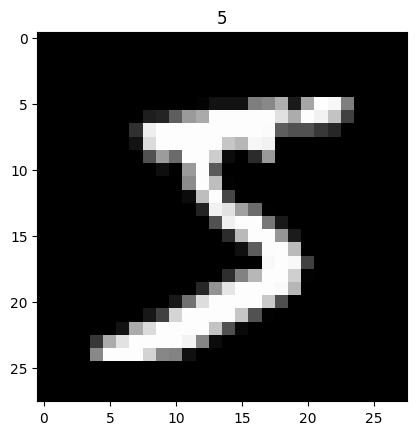

In [103]:
plt.imshow(train_loader.dataset[0][0].squeeze().numpy(), cmap='gray')
plt.title('%i' % train_loader.dataset[0][1])
plt.show()

CREATING THE MODEL

In [86]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64*7*7, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output of conv_layers for linear_layers
        x = self.linear_layers(x)

        return x



DEFINE MODEL, LOSS FUNCTION AND OPTIMIZER

In [87]:
model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

TRAINING THE MODEL

In [88]:
def train(n_epoch):
    model.train()
    total_step = len(train_loader.dataset)
    

    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f"Epoch: {n_epoch+1}, Step: [{(i+1)*len(data)}/{total_step}], Loss: {loss.item():.4f}")

In [89]:
def test():
    model.eval()
    loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss += F.cross_entropy(output, target, size_average=False).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        loss /= len(test_loader.dataset)
        print(f"\nTest Set: Average Val Loss: {loss:.4f}, Accuracy: {100*correct/total}% [{correct}/{total}]\n")
        

In [90]:
N_EPOCH = 3

for n in range(N_EPOCH):
    train(n)
    test()

Epoch: 1, Step: [6400/120000], Loss: 0.6224
Epoch: 1, Step: [12800/120000], Loss: 0.5960
Epoch: 1, Step: [19200/120000], Loss: 0.2555
Epoch: 1, Step: [25600/120000], Loss: 0.2049
Epoch: 1, Step: [32000/120000], Loss: 0.2747
Epoch: 1, Step: [38400/120000], Loss: 0.1618
Epoch: 1, Step: [44800/120000], Loss: 0.2992
Epoch: 1, Step: [51200/120000], Loss: 0.1455
Epoch: 1, Step: [57600/120000], Loss: 0.3081
Epoch: 1, Step: [64000/120000], Loss: 0.2174
Epoch: 1, Step: [70400/120000], Loss: 0.1829
Epoch: 1, Step: [76800/120000], Loss: 0.1382
Epoch: 1, Step: [83200/120000], Loss: 0.0845
Epoch: 1, Step: [89600/120000], Loss: 0.1869
Epoch: 1, Step: [96000/120000], Loss: 0.2583
Epoch: 1, Step: [102400/120000], Loss: 0.0691
Epoch: 1, Step: [108800/120000], Loss: 0.0896
Epoch: 1, Step: [115200/120000], Loss: 0.1760


/Users/joonbak/Desktop/mnist_cnn_project/new_env/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test Set: Average Val Loss: 0.0347, Accuracy: 98.82% [9882/10000]

Epoch: 2, Step: [6400/120000], Loss: 0.0828
Epoch: 2, Step: [12800/120000], Loss: 0.1611
Epoch: 2, Step: [19200/120000], Loss: 0.1471
Epoch: 2, Step: [25600/120000], Loss: 0.1594
Epoch: 2, Step: [32000/120000], Loss: 0.1322
Epoch: 2, Step: [38400/120000], Loss: 0.1594
Epoch: 2, Step: [44800/120000], Loss: 0.1096
Epoch: 2, Step: [51200/120000], Loss: 0.1611
Epoch: 2, Step: [57600/120000], Loss: 0.1711
Epoch: 2, Step: [64000/120000], Loss: 0.0696
Epoch: 2, Step: [70400/120000], Loss: 0.0544
Epoch: 2, Step: [76800/120000], Loss: 0.1509
Epoch: 2, Step: [83200/120000], Loss: 0.0690
Epoch: 2, Step: [89600/120000], Loss: 0.0305
Epoch: 2, Step: [96000/120000], Loss: 0.0807
Epoch: 2, Step: [102400/120000], Loss: 0.1786
Epoch: 2, Step: [108800/120000], Loss: 0.0540
Epoch: 2, Step: [115200/120000], Loss: 0.0455

Test Set: Average Val Loss: 0.0288, Accuracy: 99.05% [9905/10000]

Epoch: 3, Step: [6400/120000], Loss: 0.0359
Epoch: 3

In [91]:
torch.save(model.state_dict(), "Conv_model2.pt")

In [92]:
def predict(index):
    # Load the digit image
    digit_image = train_loader.dataset[index][0]
    true_label = train_loader.dataset[index][1]

    # Reshape the image tensor to 2D
    image = digit_image.squeeze().numpy()

    # Display the image
    plt.imshow(image, cmap='gray')
    plt.title(f"True Label: {true_label}")
    plt.axis('off')
    plt.show()

    # Make a prediction
    model.eval()
    with torch.no_grad():
        image = digit_image.unsqueeze(0).to(device)
        output = model(image)
        _, predicted = torch.max(output.data, 1)

    predicted_label = predicted.item()
    print(f"Predicted Label: {predicted_label}")

    # Calculate prediction accuracy
    correct = (predicted_label == true_label)
    accuracy = 100 * correct
    print(f"Prediction Accuracy: {accuracy:.2f}%")



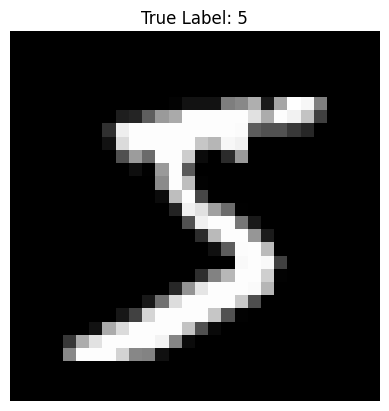

Predicted Label: 5
Prediction Accuracy: 100.00%


In [104]:
predict(0)